# Figure 2 绘图分析

本笔记本用于生成HiRES研究中的Figure 2相关图表。主要功能包括：

## 主要功能
- **细胞类型可视化**: 生成各细胞类型在发育过程中的分布图表
- **细胞周期分析**: 展示不同细胞类型的细胞周期状态分布
- **发育轨迹分析**: 可视化细胞发育轨迹和状态转换
- **多模态数据整合**: 结合RNA-seq和Hi-C数据的综合分析图表
- **统计图表生成**: 创建各种统计图表用于展示分析结果

## 图表类型
- UMAP降维可视化图
- 细胞类型分布堆积图
- 细胞周期状态热图
- 发育阶段相关的箱线图和散点图
- 基因表达模式图

## 输出结果
- 高质量的科研图表（PNG/PDF格式）
- 统计分析结果表格
- 可视化数据文件

此笔记本的输出将直接用于科研论文Figure 2的制作和数据展示。

---

In [1]:
# =============================================================================
# 包加载和资源配置
# 
# 该代码块用于加载R包和自定义函数库，为后续的单细胞数据分析提供必要的工具支持。
# 主要包括Seurat对象操作、数据可视化、并行计算等功能模块。
# =============================================================================

# 加载Seurat包，用于单细胞RNA测序数据分析
library(Seurat)

# 加载patchwork包，用于组合多个ggplot图形
library(patchwork)

# 加载tidyverse包集合，提供数据处理和可视化的一致性框架
library(tidyverse)

# 加载ggpubr包，用于增强ggplot图形的统计功能和出版质量图表制作
library(ggpubr)

# 加载自定义绘图函数库，包含项目特定的可视化函数
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")

# 加载细胞周期分析函数库，包含细胞周期相关基因分析工具
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/cellcycle_ana.R")

# 加载foreach包，提供循环迭代的增强功能
library(foreach)

# 加载doParallel包，用于注册并行后端以加速计算
library(doParallel)

NameError: name 'library' is not defined

In [ ]:
# 读取预处理完成的HiRES多模态Seurat对象
# 该对象包含细胞周期分期、细胞类型注释、RNA表达数据等完整信息
hires <- readRDS("../../hires_mouse_emb_dev.new.rds")

# 定义细胞类型的颜色映射方案
# 按照生物学功能和发育谱系进行颜色分组，便于可视化中的识别
celltypeColors = c(
  "mitosis"="#bebebe",                              # 有丝分裂期细胞 - 灰色
  "blood"="#ff9400",                                # 血液细胞 - 橙色
  "ExE endoderm"="#fec44f",                         # 胚外内胚层 - 浅黄色
  "ExE ectoderm"="#cab2d6",                         # 胚外外胚层 - 淡紫色
  "epiblast and PS"="#addd8e",                      # 上胚层和原条 - 浅绿色
  
  # 神经系统相关细胞类型 - 蓝色系渐变
  "neural ectoderm"="#AECBE6",                      # 神经外胚层 - 浅蓝色
  "NMP"="#96B9DB",                                  # 神经中胚层祖细胞 - 中蓝色
  "neural tube"="#7EA8D0",                          # 神经管 - 蓝色
  "notochord"="#6696C6",                            # 脊索 - 深蓝色
  "radial glias"="#4F85BB",                         # 放射状胶质细胞 - 较深蓝色
  "oligodendrocytes and progenitors"="#3773B1",    # 少突胶质细胞及祖细胞 - 深蓝色
  "early neurons"="#1F62A6",                        # 早期神经元 - 更深蓝色
  "schwann cell precursors"="#08519C",              # 雪旺细胞前体 - 最深蓝色
  
  # 中胚层相关细胞类型 - 红色系渐变
  "early mesoderm"="#FC9272",                       # 早期中胚层 - 浅红色
  "ExE mesoderm"="#EF7F64",                         # 胚外中胚层 - 红色
  "early mesenchyme"="#E36C57",                     # 早期间充质 - 中红色
  "intermediate mesoderm"="#D6594A",                # 中间中胚层 - 深红色
  "myocytes"="#CA473C",                             # 肌细胞 - 较深红色
  "mix late mesenchyme"="#BD342F",                  # 混合晚期间充质 - 深红色
  
  # 其他细胞类型
  "endoderm"="#fe9929",                             # 内胚层 - 橙色
  "epithelial cells"="#fa9fb5"                      # 上皮细胞 - 粉色
)

# 定义细胞周期各阶段的颜色映射
# 颜色按照细胞周期的生物学顺序从紫色到绿色再到橙色渐变
cellcyclecolors = c(
  "G0"="#762a83",          # G0期(静止期) - 深紫色
  "G1"="#c2a5cf",          # G1期(DNA合成前期) - 浅紫色
  "Early-S"="#99d8c9",     # 早S期(DNA合成早期) - 浅青绿色
  "Mid-S"="#66c2a4",       # 中S期(DNA合成中期) - 青绿色
  "Late-S"="#41ae76",      # 晚S期(DNA合成晚期) - 绿色
  "G2"="#238b45",          # G2期(DNA合成后期) - 深绿色
  "M"="#ea6e34"            # M期(有丝分裂期) - 橙色
)

In [ ]:
# 创建细胞类型分组的颜色映射
# 将原有的颜色方案复制为分组颜色，并使用数字索引作为名称
# 这种处理方式便于在某些可视化函数中使用数字化的颜色索引
celltype_group_colors <- celltypeColors
names(celltype_group_colors) <- as.character(seq(length(celltypeColors)))

`summarise()` has grouped output by 'celltype', 'cluster', 'sub_k_cluster'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


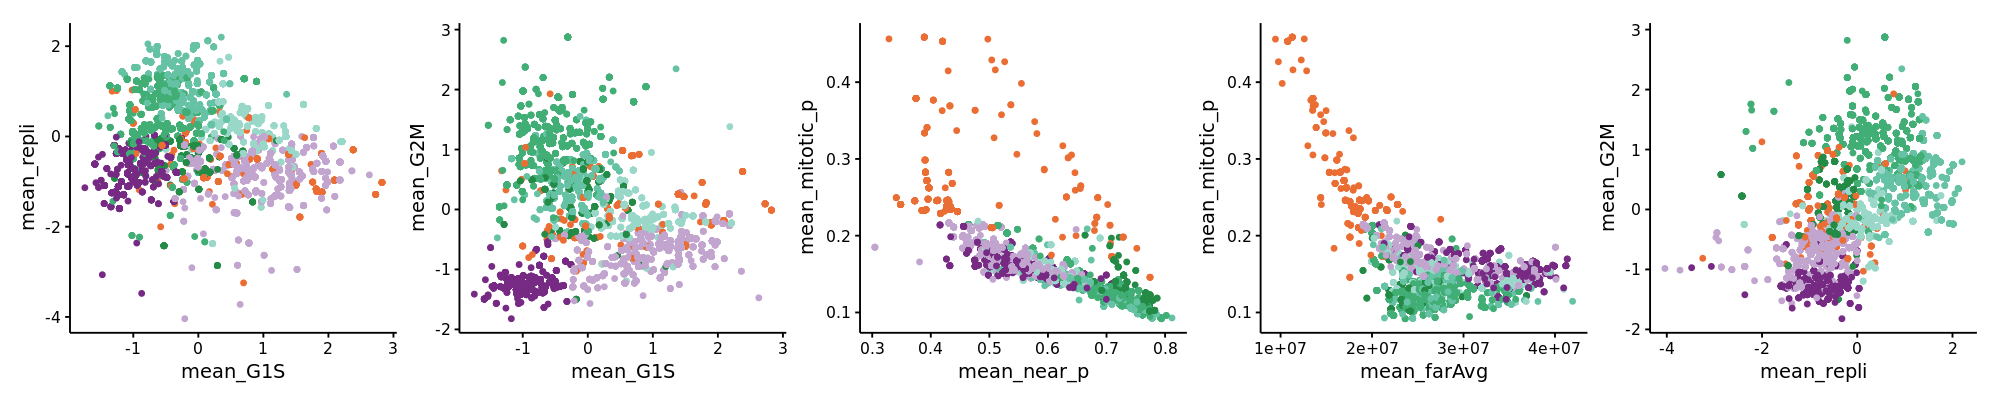

In [ ]:
# 生成细胞周期特征的多维散点图组合
# 按细胞类型、聚类和子聚类分组，计算各种特征的均值用于可视化

# 对HiRES数据进行分组统计，计算每个细胞群的细胞周期相关特征均值
data <- hires[[]] %>%  
  group_by(celltype, cluster, sub_k_cluster) %>% 
  summarise(
    count = n(),                              # 每组的细胞数量
    mean_G1S = mean(G1S.Score),               # G1/S期评分均值
    mean_G2M = mean(G2M.Score),               # G2/M期评分均值
    mean_repli = mean(repli_score),           # 复制时间评分均值
    mean_near_p = mean(near_p),               # 近距离接触百分比均值
    mean_mitotic_p = mean(mitotic_p),         # 有丝分裂期特征评分均值
    mean_farAvg = mean(farAvg),               # 远距离接触平均强度
    cellcycle_threshold = cellcycle_threshold  # 细胞周期阶段标签
  )

# 创建五个散点图展示不同特征组合与细胞周期分期的关系
# 图a：G1/S评分 vs 复制时间评分
a <- data %>%  ggplot() + 
  geom_point(aes(x=mean_G1S, y=mean_repli, color=cellcycle_threshold), size = 0.5) + 
  scale_color_manual(values=cellcyclecolors) + 
  theme_Publication() + 
  NoLegend()

# 图b：G1/S评分 vs G2/M评分  
b <- data %>% ggplot() + 
  geom_point(aes(x=mean_G1S, y=mean_G2M, color=cellcycle_threshold), size = 0.5) + 
  scale_color_manual(values=cellcyclecolors) + 
  theme_Publication() +  
  NoLegend()

# 图c：近距离接触百分比 vs 有丝分裂期特征
c <- data %>% ggplot() + 
  geom_point(aes(x=mean_near_p, y=mean_mitotic_p, color=cellcycle_threshold), size = 0.5) + 
  scale_color_manual(values=cellcyclecolors) + 
  theme_Publication() +  
  NoLegend()

# 图d：远距离接触强度 vs 有丝分裂期特征
d <- data %>% ggplot() + 
  geom_point(aes(x=mean_farAvg, y=mean_mitotic_p, color=cellcycle_threshold), size = 0.5) + 
  scale_color_manual(values=cellcyclecolors) + 
  theme_Publication() + 
  NoLegend()

# 图e：复制时间评分 vs G2/M评分
e <- data %>% ggplot() + 
  geom_point(aes(x=mean_repli, y=mean_G2M, color=cellcycle_threshold), size = 0.5) + 
  scale_color_manual(values=cellcyclecolors) + 
  theme_Publication() +  
  NoLegend()

# 设置图形输出参数：宽度10英寸，高度2英寸，分辨率200dpi
options(repr.plot.width=10, repr.plot.height=2, repr.plot.res=200)

# 将五个散点图横向拼接展示，全面展示细胞周期分期的质量
(a | b | c | d | e)

In [ ]:
# 将细胞周期特征散点图组合保存为PDF文件
# 保存为高质量的矢量图格式，用于科研论文发表
(a | b | c | d | e) %>% ggsave(filename = "cellcycle_annotation_scatter.pdf", width = 7.5, height = 1.5)

# Figure2

In [ ]:
# 设置后续图形的显示参数
# 调整图形大小为正方形格式，适合单个图表的展示
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)

In [ ]:
# 重复设置图形显示参数（与上一个单元格相同）
# 确保图形输出为4x4英寸的正方形格式，分辨率200dpi
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res=200)

Joining, by = "celltype"


In [ ]:
# 重新构建Seurat对象的元数据，添加细胞类型分组信息
# 为后续的可视化分析准备规范化的元数据结构

# 创建细胞类型与分组ID的映射表，并与原有元数据合并
hires@meta.data <- tibble(celltype = names(celltypeColors)) %>% 
  mutate(group_id = row_number()) %>%           # 为每种细胞类型分配唯一的组别ID (1,2,3...)
  left_join(hires[[]]) %>%                      # 左连接原有的细胞元数据，保留所有细胞信息
  mutate(temp = cellname) %>%                   # 创建临时列保存细胞名称
  column_to_rownames("temp") %>%                # 将细胞名称设为行名
  arrange(cellname)                             # 按细胞名称排序确保数据一致性

# 这样处理后，每个细胞都有了对应的group_id，便于在可视化中使用数字索引

In [ ]:
# 生成基于RNA数据的UMAP可视化图（带图例版本）
# 使用group_id进行着色，展示不同细胞类型在RNA表达空间中的分布

# 创建UMAP降维图，按细胞类型分组着色
p <- DimPlot(hires, 
             label = T,                          # 显示标签
             label.size = 2,                     # 标签字体大小
             repel = T,                          # 标签互斥避免重叠
             pt.size = 0.05,                     # 点的大小
             reduction = "umap",                 # 使用RNA-UMAP降维结果
             group.by = "group_id",              # 按组别ID分组着色
             cols = celltype_group_colors) +     # 使用预定义的细胞类型颜色
  theme_Publication() +                         # 应用发表级主题样式
  ggtitle("")                                   # 移除默认标题

# 自定义图形样式：移除坐标轴刻度和标签，添加自定义轴标签
p <- p + theme(
  axis.ticks.x = element_blank(),               # 移除x轴刻度线
  axis.text.x = element_blank(),                # 移除x轴刻度标签
  axis.ticks.y = element_blank(),               # 移除y轴刻度线  
  axis.text.y = element_blank()                 # 移除y轴刻度标签
) + 
xlab("RNA UMAP 1") +                            # 设置x轴标签
ylab("RNA UMAP 2") +                            # 设置y轴标签
theme(legend.position = "right")                # 将图例放置在右侧

# 显示图形
p

# 保存高质量PDF图形文件
p %>% ggsave(filename = "umap_main_RNA.pdf", height = 2, width = 3.5, dpi = 300, units = "in")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


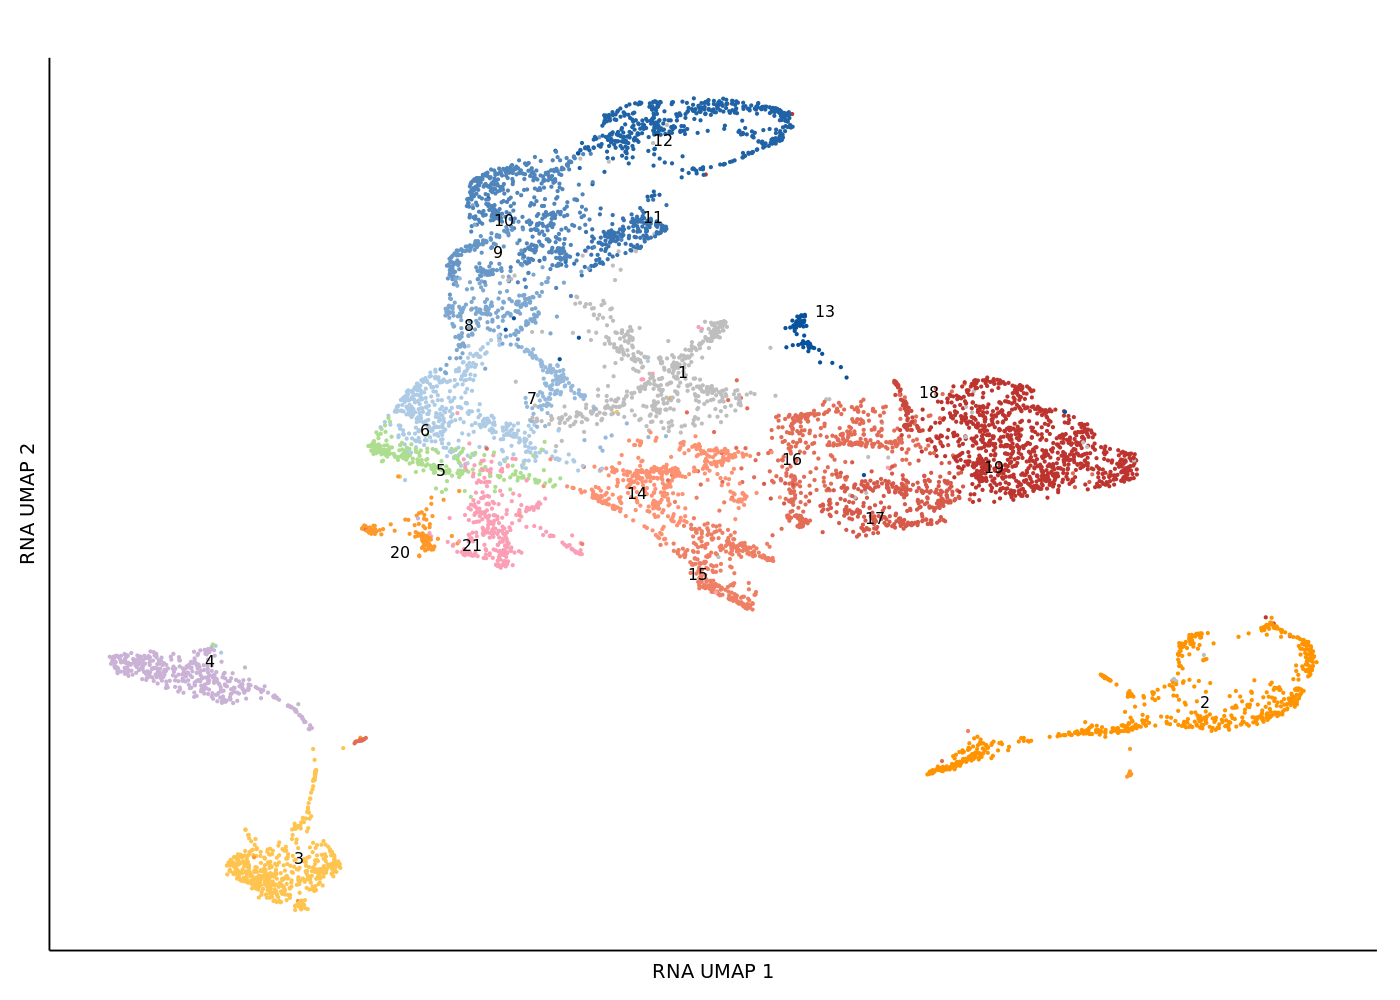

In [ ]:
# 生成基于RNA数据的UMAP可视化图（无图例版本）
# 与上一个图相同，但移除图例以节省空间，适用于多图组合展示

# 创建UMAP降维图，设置与上图相同的参数
p <- DimPlot(hires, 
             label = T,                          # 显示标签
             label.size = 2,                     # 标签字体大小
             repel = T,                          # 标签互斥避免重叠
             pt.size = 0.05,                     # 点的大小
             reduction = "umap",                 # 使用RNA-UMAP降维结果
             group.by = "group_id",              # 按组别ID分组着色
             cols = celltype_group_colors) +     # 使用预定义的细胞类型颜色
  theme_Publication() +                         # 应用发表级主题样式
  ggtitle("")                                   # 移除默认标题

# 自定义图形样式并移除图例
p <- p + theme(
  axis.ticks.x = element_blank(),               # 移除x轴刻度线
  axis.text.x = element_blank(),                # 移除x轴刻度标签
  axis.ticks.y = element_blank(),               # 移除y轴刻度线
  axis.text.y = element_blank()                 # 移除y轴刻度标签
) + 
xlab("RNA UMAP 1") +                            # 设置x轴标签
ylab("RNA UMAP 2") +                            # 设置y轴标签
theme(legend.position = "right") +              # 图例位置（将被NoLegend覆盖）
NoLegend()                                      # 移除图例

# 显示图形
p

# 保存为更紧凑的PDF文件（宽度更小）
p %>% ggsave(filename = "umap_main_RNA_nolegend.pdf", height = 2, width = 2, dpi = 300, units = "in")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


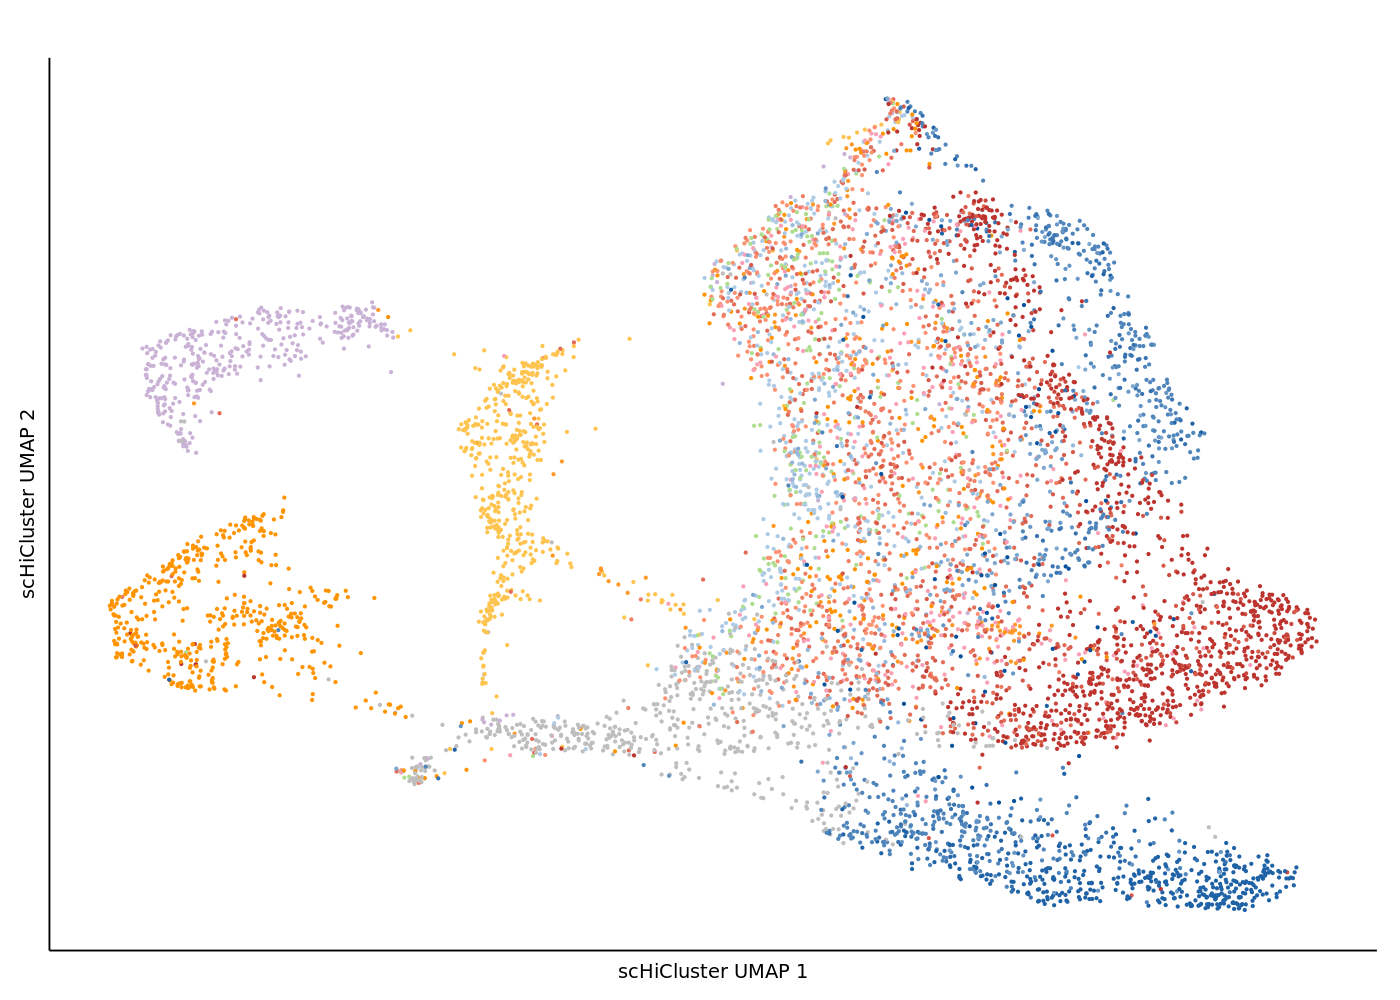

In [ ]:
# 生成基于Hi-C数据的UMAP可视化图（scHiCluster方法）
# 使用Hi-C接触数据进行降维，展示细胞类型在染色质结构空间中的分布

# 创建基于Hi-C数据的UMAP降维图
p <- DimPlot(hires, 
             label = F,                          # 不显示标签（避免图形拥挤）
             reduction = "schiclusterumap",       # 使用scHiCluster方法的UMAP结果
             group.by = "celltype",              # 按细胞类型分组着色
             cols = celltypeColors,              # 使用细胞类型专用颜色方案
             pt.size = 0.05) +                  # 设置点的大小
  theme_Publication() +                         # 应用发表级主题样式
  ggtitle("") +                                 # 移除默认标题
  NoLegend()                                    # 移除图例

# 自定义图形样式：移除坐标轴元素，添加专门的Hi-C UMAP轴标签
p <- p + theme(
  axis.ticks.x = element_blank(),               # 移除x轴刻度线
  axis.text.x = element_blank(),                # 移除x轴刻度标签
  axis.ticks.y = element_blank(),               # 移除y轴刻度线
  axis.text.y = element_blank()                 # 移除y轴刻度标签
) + 
xlab("scHiCluster UMAP 1") +                    # 设置x轴标签，标明这是Hi-C数据的UMAP
ylab("scHiCluster UMAP 2")                      # 设置y轴标签

# 显示图形
p

# 保存Hi-C UMAP图为PDF文件
p %>% ggsave(filename = "umap_main_HiC_nolegend.pdf", height = 2, width = 2, dpi = 300, units = "in")

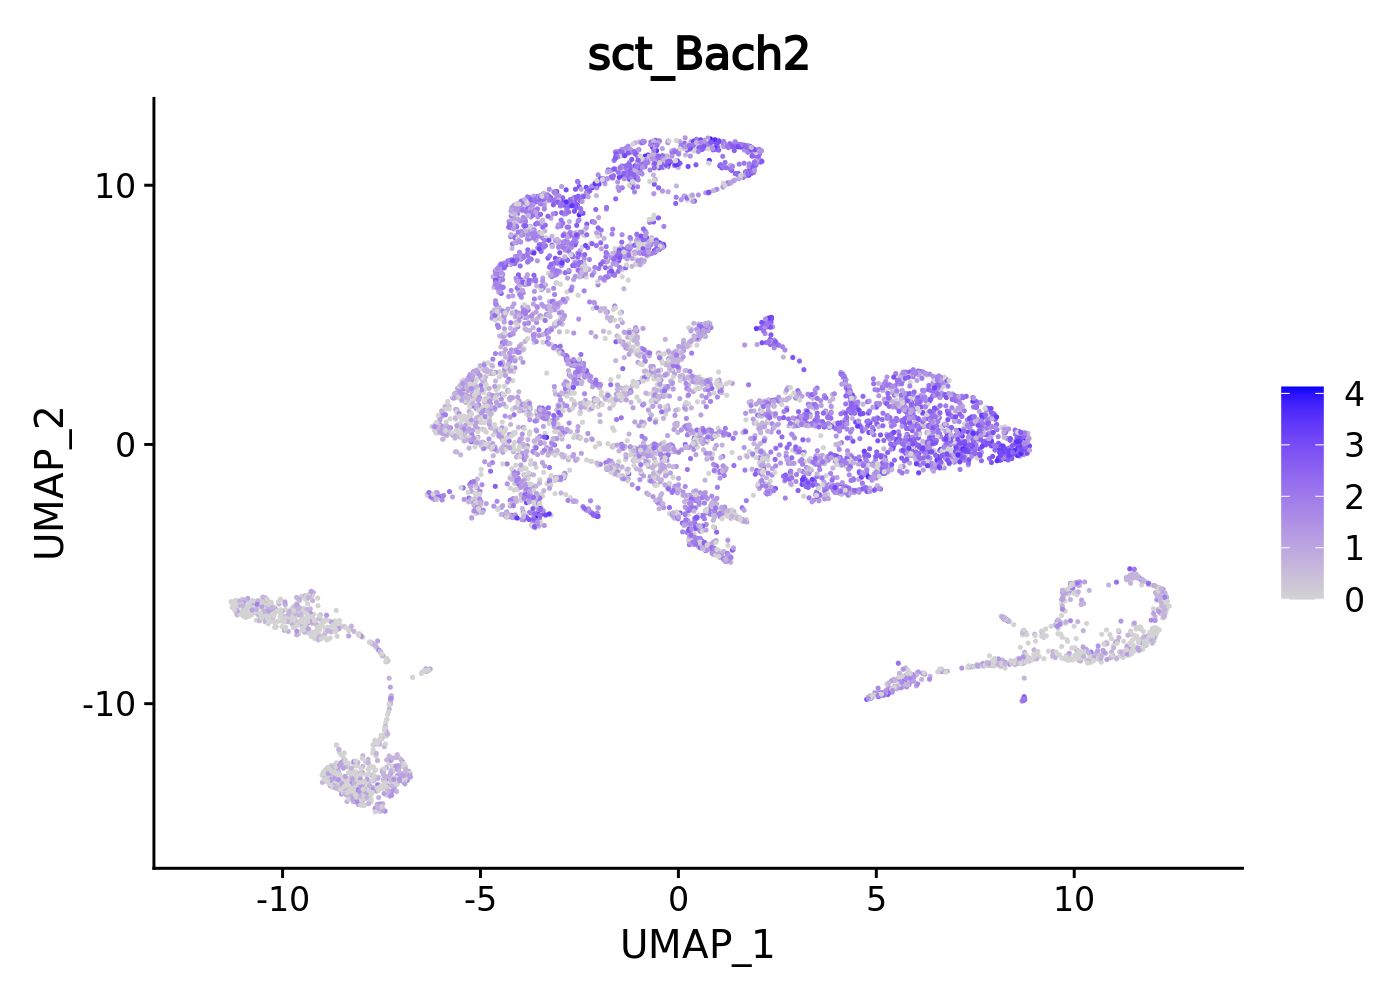

In [ ]:
# 绘制Bach2基因在RNA-UMAP空间中的表达特征图
# Bach2是转录因子，在免疫细胞发育中起重要作用
FeaturePlot(hires, "sct_Bach2", reduction = "umap")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


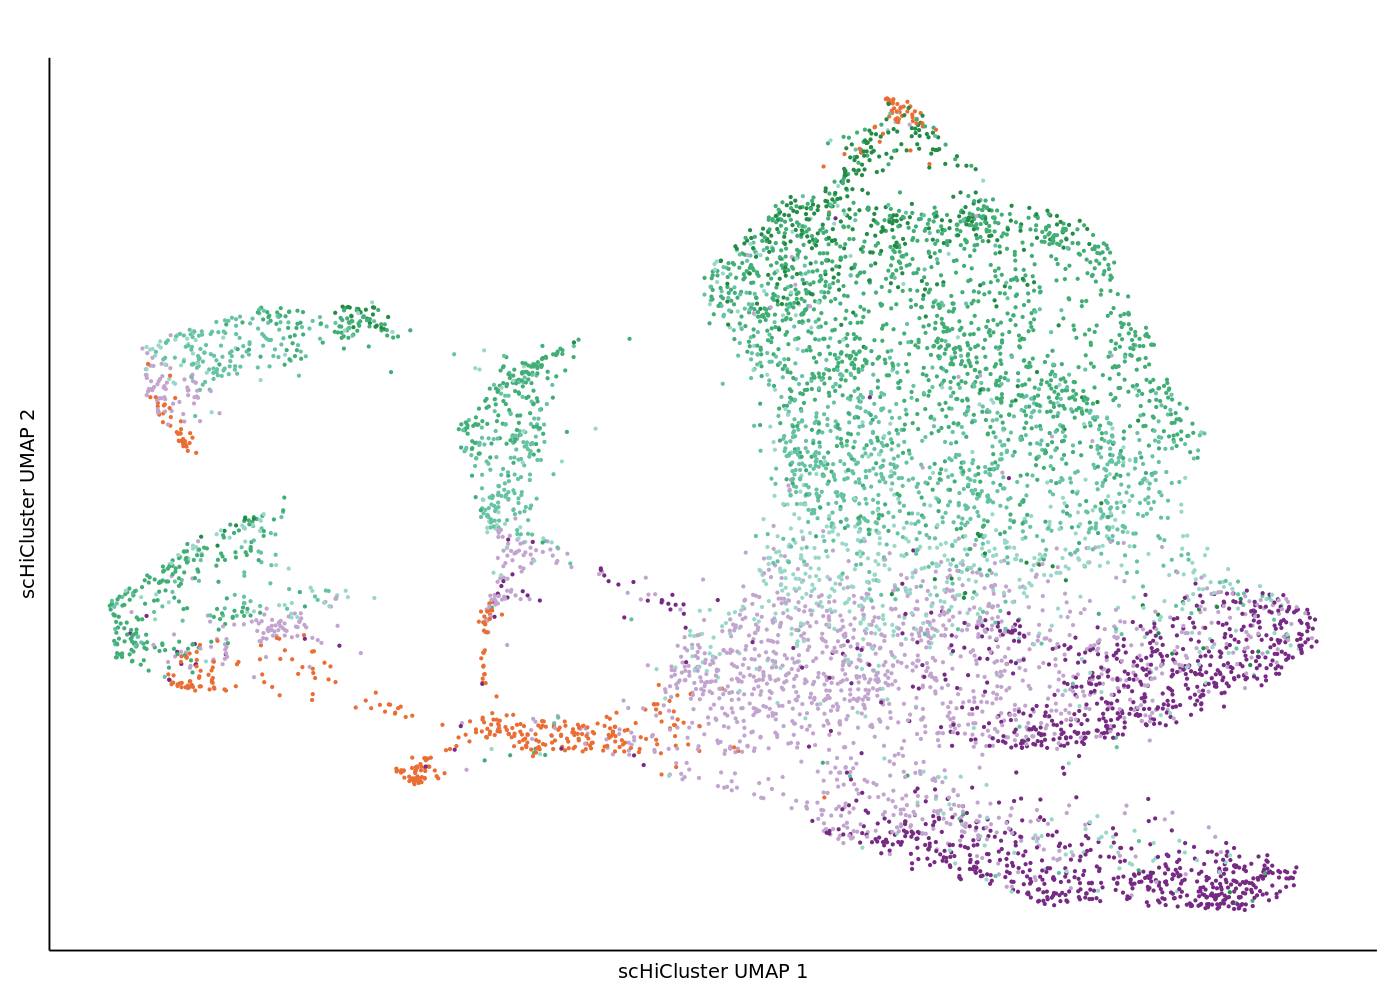

In [ ]:
# 在Hi-C UMAP空间中可视化细胞周期状态分布
# 展示细胞周期分期结果在染色质结构降维空间中的表现

# 创建基于Hi-C数据的细胞周期UMAP图
p <- DimPlot(hires, 
             label = F,                          # 不显示标签
             repel = F,                          # 不使用标签互斥
             reduction = "schiclusterumap",       # 使用Hi-C UMAP降维结果
             group.by = "cellcycle_threshold",    # 按细胞周期阶段分组着色
             cols = cellcyclecolors,             # 使用细胞周期专用颜色方案
             pt.size = 0.05) +                  # 设置点的大小
  theme_Publication() +                         # 应用发表级主题样式
  ggtitle("") +                                 # 移除默认标题
  theme(legend.position = "right",              # 设置图例位置
        legend.direction = "vertical")          # 设置图例方向

# 自定义图形样式并最终移除图例
p <- p + theme(
  axis.ticks.x = element_blank(),               # 移除x轴刻度线
  axis.text.x = element_blank(),                # 移除x轴刻度标签
  axis.ticks.y = element_blank(),               # 移除y轴刻度线
  axis.text.y = element_blank()                 # 移除y轴刻度标签
) + 
xlab("scHiCluster UMAP 1") +                    # 设置x轴标签
ylab("scHiCluster UMAP 2") +                    # 设置y轴标签
theme(legend.position = "bottom",               # 将图例位置改为底部
      legend.direction = "horizontal") +        # 设置图例为水平方向
NoLegend()                                      # 最终移除图例

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


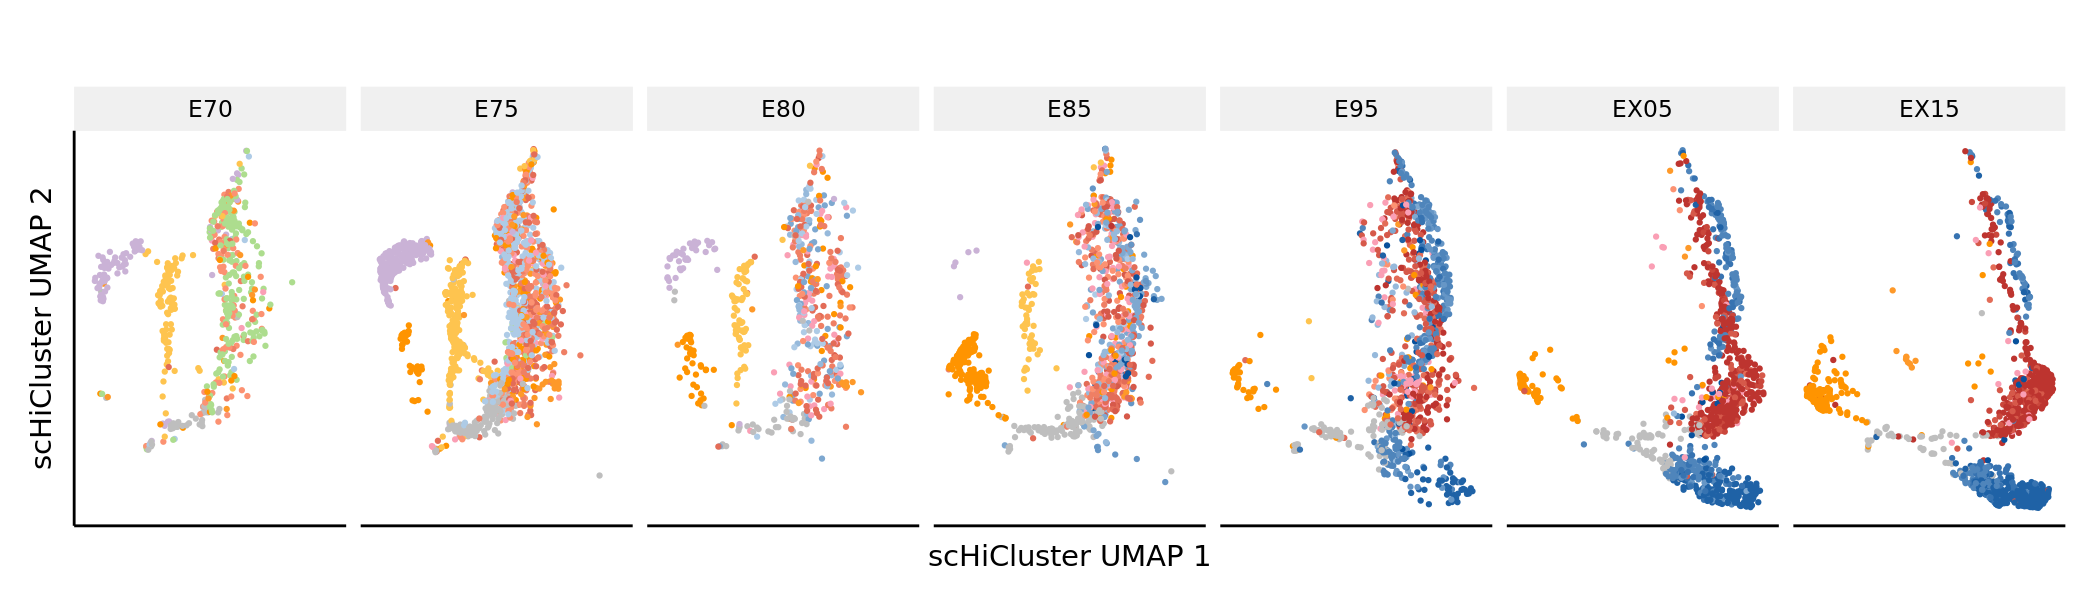

In [ ]:
# 设置图形输出参数，指定宽度、高度和分辨率
options(repr.plot.width=7, repr.plot.height=2,repr.plot.res=300)

# 创建DimPlot可视化对象，用于展示单细胞Hi-C数据的UMAP降维结果
# 按发育阶段分面显示，不显示标签和排斥力布局
# 使用指定的细胞类型颜色方案，点大小设置为0.05

# 创建一个降维可视化图，使用DimPlot函数绘制空间转录组数据
# 参数:
#   hires - 高分辨率的图像对象
#   label - 是否在图上添加标签，设置为FALSE不显示标签
#   repel - 是否避免标签重叠，设置为FALSE不启用
#   reduction - 降维方法，使用"schiclusterumap"方法
#   group.by - 分组依据，按"celltype"细胞类型分组
#   cols - 颜色映射，使用预定义的celltypeColors颜色方案
#   pt.size - 点的大小，设置为0.05
#   split.by - 分面依据，按"stage"阶段分割图形
# 返回值: 返回一个ggplot对象，包含主题样式和坐标轴设置

p <- DimPlot(hires,label=F,repel = F,reduction = "schiclusterumap",group.by = "celltype",cols=celltypeColors,pt.size=0.05,split.by="stage") + theme_Publication() + 
    ggtitle("")  + theme(legend.position = "right",legend.direction = "vertical") + NoLegend() + 
      scale_x_continuous(breaks = c(-6,-1,4))
# 移除坐标轴刻度和文本标签，添加自定义坐标轴标题
p <- p + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("scHiCluster UMAP 1") + ylab("scHiCluster UMAP 2")

# 显示绘图对象
p

# 保存绘图为PDF格式，设置文件名、尺寸和分辨率
p %>% ggsave(filename = "umap_main_stageHiC.pdf",height = 2, width =8,dpi=300,units ="in")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


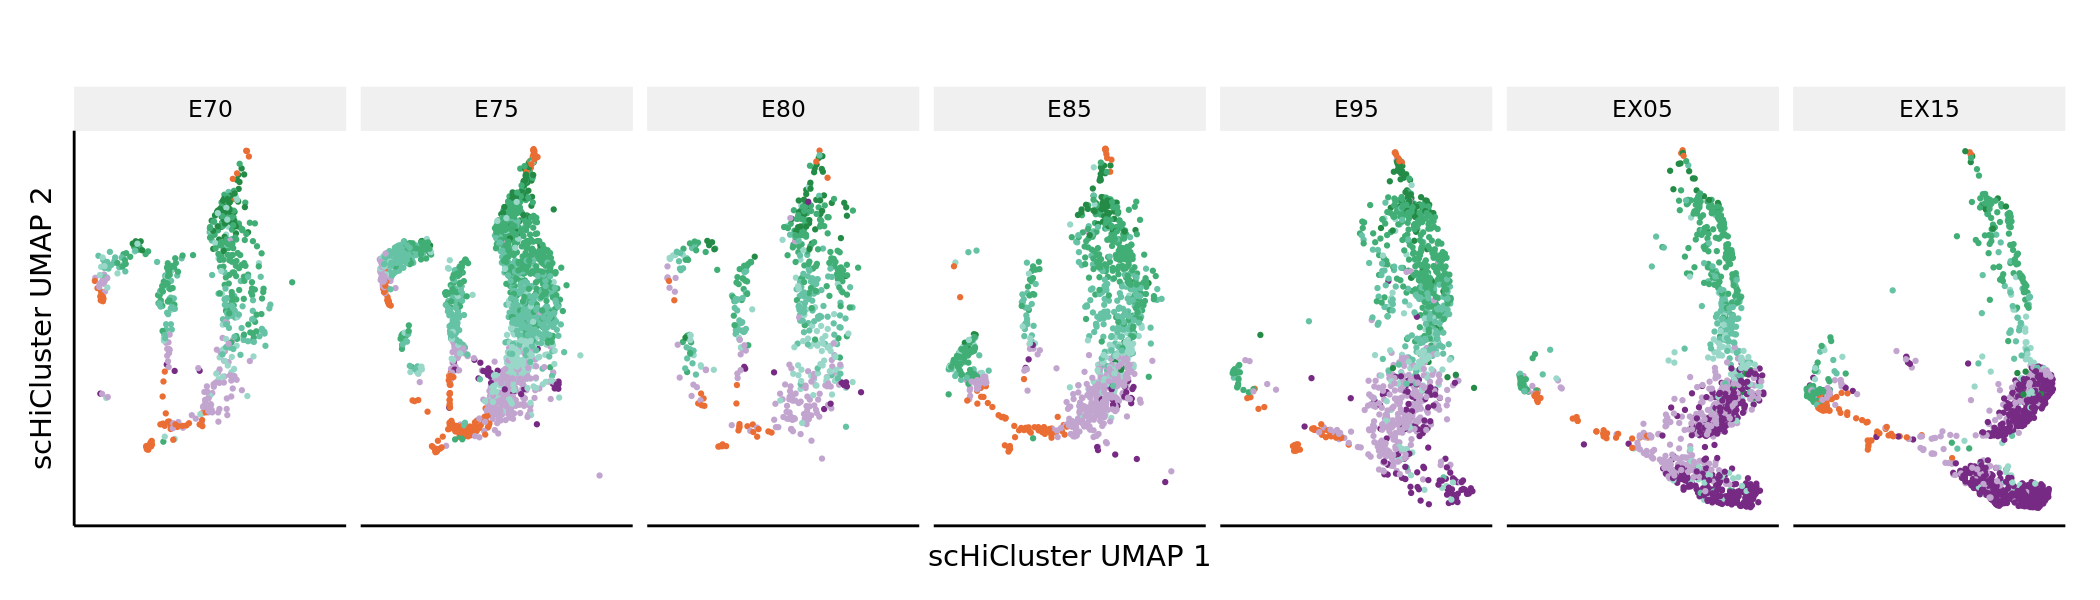

In [ ]:
# 设置图形输出参数，指定宽度、高度和分辨率
options(repr.plot.width=7, repr.plot.height=2,repr.plot.res=300)

# 创建DimPlot可视化对象，用于展示细胞周期在不同发育阶段的UMAP降维结果
# hires: 高分辨率数据对象
# label: 是否显示标签（FALSE表示不显示）
# repel: 是否避免标签重叠（FALSE表示不避免）
# reduction: 降维方法，使用"schiclusterumap"
# group.by: 按"cellcycle_threshold"分组着色
# cols: 使用预定义的cellcyclecolors颜色方案
# pt.size: 点的大小设置为0.05
# split.by: 按"stage"变量分面显示
# theme_Publication(): 应用出版级主题
# ggtitle(""): 移除图形标题
# theme(legend.position = "right",legend.direction = "vertical"): 设置图例位置和方向
# NoLegend(): 隐藏图例
# scale_x_continuous(breaks = c(-6,-1,4)): 设置x轴刻度位置
p <- DimPlot(hires,label=F,repel = F,reduction = "schiclusterumap",group.by = "cellcycle_threshold",cols=cellcyclecolors,pt.size=0.05,split.by="stage") + theme_Publication() + 
    ggtitle("")  + theme(legend.position = "right",legend.direction = "vertical") + NoLegend() + 
      scale_x_continuous(breaks = c(-6,-1,4))

# 移除坐标轴刻度和文本标签，并添加坐标轴标题
p <- p + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("scHiCluster UMAP 1") + ylab("scHiCluster UMAP 2")

# 显示图形对象
p

# 保存图形为PDF文件
# filename: 输出文件名
# height: 图形高度（英寸）
# width: 图形宽度（英寸）
# dpi: 分辨率
# units: 单位设置为英寸
p %>% ggsave(filename = "umap_main_stageHiC_cellcycle.pdf",height = 2, width =8,dpi=300,units ="in")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


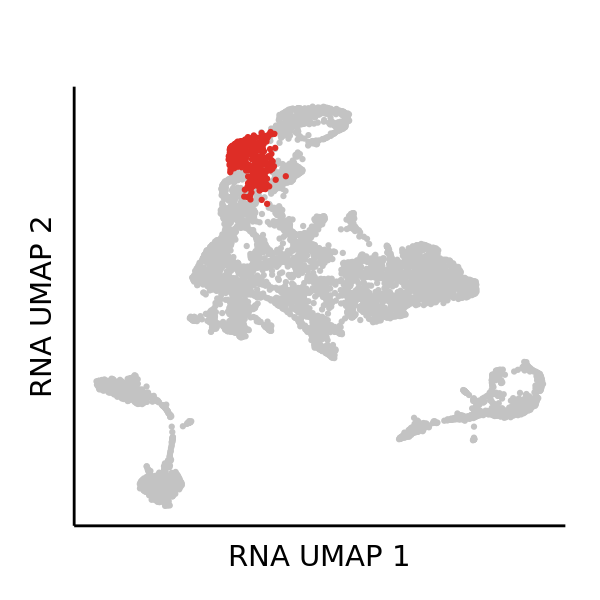

In [ ]:
options(repr.plot.width=2, repr.plot.height=2,repr.plot.res=300)
b <- DimPlot(hires,label=F,reduction = "umap",group.by = "celltype",cells.highlight = list(neuralecto = hires[[]] %>% filter(celltype == "radial glias") %>%pull(cellname))
          ,raster=F,pt.size=0.05,  sizes.highlight = 0.05) + theme_Publication() + NoLegend() + ggtitle("")
b <- b + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("RNA UMAP 1") + ylab("RNA UMAP 2")
b
b %>% ggsave(filename = "umap_RNA_rg.pdf",height = 2, width =2,dpi=300,units ="in")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


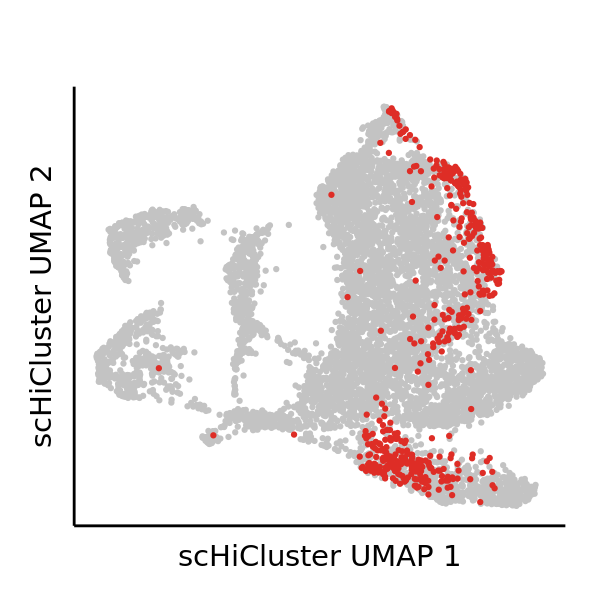

In [ ]:
options(repr.plot.width=2, repr.plot.height=2,repr.plot.res=300)
b <- DimPlot(hires,label=F,reduction = "schiclusterumap",group.by = "celltype",cells.highlight = list(neuralecto = hires[[]] %>% filter(celltype == "radial glias") %>%pull(cellname)),
 ,raster=F,pt.size=0.05,  sizes.highlight = 0.05) + theme_Publication() + NoLegend() + ggtitle("")
b <- b + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("scHiCluster UMAP 1") + ylab("scHiCluster UMAP 2")
b
b %>% ggsave(filename = "umap_HiC_rg.pdf",height = 2, width =2,dpi=300,units ="in")

In [ ]:
hires

ERROR: Error in eval(expr, envir, enclos): object 'hires' not found


In [ ]:
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/hires_utils.R")
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/cellcycle_ana.R")


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [ ]:
library(cellAlign)

In [ ]:
hires_cc <- subset(hires,subset = cellcycle_threshold %in% c("G1","Early-S","Mid-S","Late-S","G2"))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from cpg_umap_ to cpgumap_”
Warning message:
“Cannot add objects with duplicate keys (offending key: cpgumap_) setting key to original value 'cpg_umap_'”


In [ ]:
registerDoParallel(20)
middle_shift <- foreach(i = seq(1:4000),.combine = "c",.errorhandling = "remove") %dopar% {
     out <- align_cellcycle(hires_cc,'celltype!= "sample1" & stage == "E95"','celltype!= "sample2" & stage == "E95"',sample_number=300)
     out[2][[1]][[1]]
 }
early_shift <- foreach(i = seq(1:4000),.combine = "c",.errorhandling = "remove") %dopar% {
    out <- align_cellcycle(hires_cc,'stage == "E75"','stage == "E95"',sample_number=300)
    out[2][[1]][[1]]
}
late_shift <- foreach(i = seq(1:4000),.combine = "c",.errorhandling = "remove") %dopar% {
    out <- align_cellcycle(hires_cc,'stage == "EX15"','stage == "E95"',sample_number=300)
    out[2][[1]][[1]]
}

a <- middle_shift %>% as.data.frame() %>% mutate(type = "E9.5 vs. E9.5")
b <- early_shift %>% as.data.frame() %>% mutate(type = "E7.5 vs. E9.5")
c <- late_shift %>% as.data.frame() %>% mutate(type = "E11.5 vs. E9.5")
neural_shift <- rbind(a,b,c)
names(neural_shift) <- c("shift","type")

In [ ]:
neural_shift %>% mutate(shift = as.numeric(shift)) -> neural_shift

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”
Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


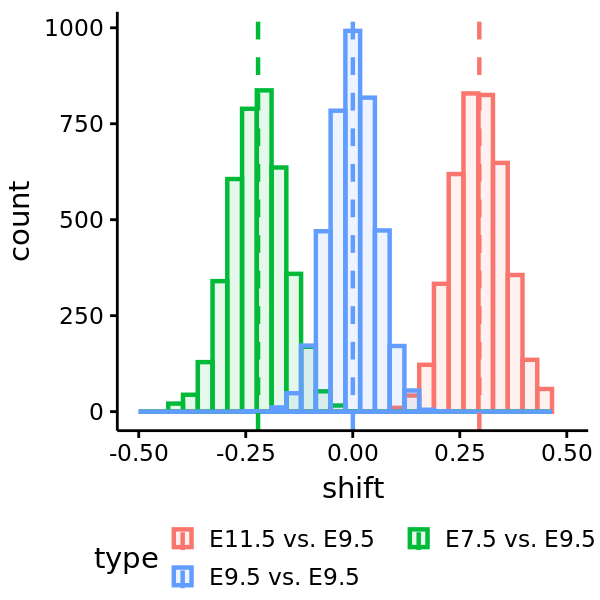

In [ ]:
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)
p<-neural_shift %>% gghistogram(x="shift",bins= 30,fill = "type",color= "type",alpha = 0.1,add="mean") + 
    theme_Publication() + scale_x_continuous(limits = c(-0.5,0.5)) + 
    theme(legend.position = "bottom", legend.direction = "horizontal", legend.margin=margin()) + 
    guides(color=guide_legend(nrow=2,byrow=TRUE))
p %>% ggsave(filename = "stage_shift.pdf",height = 2,width = 2,dpi = 300, units = "in") 
p

In [ ]:
celltype1 <- 'celltype == "neural ectoderm"'  
celltype2 <- 'celltype == "neural tube"'
celltype3 <- 'celltype == "radial glias"' 

early <- align_cellcycle(hires_cc,celltype1,celltype2,numPts = 30)[3][[1]]
late <- align_cellcycle(hires_cc,celltype2,celltype3,numPts = 30)[3][[1]]

plotData <- rbind(early,late %>% mutate(align = - align)) %>% ungroup() %>% filter(variable != "diff")
plotData$variable <- factor(plotData$variable, levels = rev(c("neural ectoderm","neural tube","radial glias")))

Joining, by = "cellname"
Joining, by = "cellname"
calculate dissimilarity matrix

calculate cost and step matrices

backtracking

Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "metaNodeRef"
Joining, by = "metaNodeQuery"
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Joining, by = "cellname"
Joining, by = "cellname"
calculate dissimilarity matrix

calculate cost and step matrices

backtracking

Joining, by = "cellname"
Joining, by = "cellname"
Joining, by = "metaNodeRef"
Joining, by = "metaNodeQuery"
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


Warning message:
“Ignoring unknown aesthetics: width”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


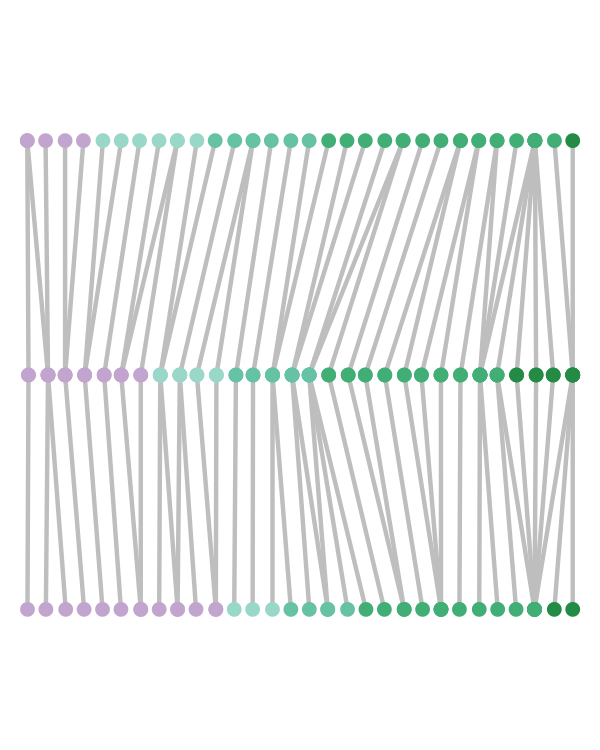

In [ ]:
options(repr.plot.width=2,repr.plot.height=2.5,repr.plot.res=300)
alignment_plot <- ggplot(plotData %>% filter(variable != "diff"), aes(x = variable, y = value, group = align)) + 
            geom_line(color = "grey",aes(width = 0.05)) + theme_bw() + geom_point(aes(color = cellcycle),size = 1) + 
            coord_flip() + theme_Publication() + NoLegend() + scale_color_manual(values = cellcyclecolors)+
            xlab("") + ylab("cellcycle")
alignment_plot <- alignment_plot + theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()
            )+ theme_void() + NoLegend() + xlab("") + ylab("")
alignment_plot
alignment_plot%>% ggsave(filename = "align.pdf",height = 2,width = 3,dpi = 300, units = "in") 

In [ ]:
# cellcycle - HiC - RNA clustering comparison 

In [ ]:
hires <- FindClusters(hires,graph.name = "sch.nn",future.seed=TRUE,resolution = 1.9)

Warning message:
“The following arguments are not used: future.seed”
Warning message:
“The following arguments are not used: future.seed”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7469
Number of edges: 69733

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7251
Number of communities: 24
Elapsed time: 0 seconds


3 singletons identified. 21 final clusters.



In [ ]:
library(circlize)
col_fun = colorRamp2(seq(from = 0,to=1,length.out = 8), c("#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#b10026"))

In [ ]:
# cellcycle - HiC - RNA clustering comparison 
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","early neurons"="#1F62A6","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)

RNA_hic_mat <- hires[[]] %>% select(cellcycle_threshold,celltype,sch.nn_res.1.9) %>% group_by(sch.nn_res.1.9) %>% 
    mutate(cellnum_hictype = n()) %>% group_by(celltype,sch.nn_res.1.9) %>% mutate(RNAnum_in_hic = n(),percent = RNAnum_in_hic/cellnum_hictype)  %>% 
        select(celltype,sch.nn_res.1.9,percent) %>% unique() %>% ungroup() %>% spread(sch.nn_res.1.9,percent) %>% column_to_rownames("celltype")
RNA_hic_mat[is.na(RNA_hic_mat)] <- 0

cellcycle_hic_mat <- hires[[]] %>% select(cellcycle_threshold,celltype,sch.nn_res.1.9) %>% group_by(sch.nn_res.1.9) %>% 
    mutate(cellnum_hictype = n()) %>% group_by(cellcycle_threshold,sch.nn_res.1.9) %>% mutate(cellcycle_thresholdnum_in_hic = n(),percent = cellcycle_thresholdnum_in_hic/cellnum_hictype)  %>% 
        select(cellcycle_threshold,sch.nn_res.1.9,percent) %>% unique() %>% ungroup() %>% spread(sch.nn_res.1.9,percent) %>% column_to_rownames("cellcycle_threshold")
cellcycle_hic_mat[is.na(cellcycle_hic_mat)] <- 0

#order <- cellcycle_hic_mat%>% t() %>% as.data.frame() %>% names()
order <- c("G0","G1","Early-S","Mid-S","Late-S","G2","M")
cellcycle_hic_mat <- cellcycle_hic_mat[order,c("15","2","16","17","8","9","0","3","5","10","7","11","14","12","1","4","13","18","20","6","19")]

annoDF <- cellcyclecolors %>% as.data.frame() %>% rownames_to_column("cellcycle") %>% mutate(temp=cellcycle) %>% column_to_rownames("temp") 
names(annoDF)[2] <- "colorValue"
annoDF$cellcycle <- factor(annoDF$cellcycle ,levels = order)
annoDF <- annoDF %>% arrange(cellcycle)

topAnno <- HeatmapAnnotation(cellcycle = anno_simple(annoDF%>% select(cellcycle),col = cellcyclecolors),
                             gap = unit(c(10), "mm"),show_annotation_name=FALSE)
                  #pch = annoDF %>% pull(cellcycle)),

options(repr.plot.width=7, repr.plot.height=5,repr.plot.res=200)
p <- cellcycle_hic_mat %>% t() %>% Heatmap(col_fun,top_annotation = topAnno,cluster_columns = FALSE,cluster_rows = FALSE, row_dend_reorder = TRUE,column_dend_reorder = TRUE,
               heatmap_legend_param = list(title = "CC cell %"))

order <- names(celltypeColors)
RNA_hic_mat <- RNA_hic_mat[order,c("15","2","16","17","8","9","0","3","5","10","7","11","14","12","1","4","13","18","20","6","19")]
#order <- RNA_hic_mat%>% t() %>% as.data.frame() %>% names()

annoDF <- celltypeColors%>% as.data.frame() %>% rownames_to_column("celltype") %>% mutate(celltype_id = row_number(),temp=celltype) %>% column_to_rownames("temp") 
annoDF$celltype_id <- as.character(annoDF$celltype_id)
names(annoDF)[2] <- "colorValue"
annoDF$celltype <- factor(annoDF$celltype ,levels = order)
annoDF <- annoDF %>% arrange(celltype)

topAnno <- HeatmapAnnotation(celltype = anno_simple(annoDF%>% select(celltype),col = celltypeColors,
                  ),show_annotation_name=FALSE,
                 gap = unit(c(10), "mm"))

q <- RNA_hic_mat%>% t() %>% Heatmap(top_annotation = topAnno,col_fun,column_dend_reorder = TRUE,show_column_names = FALSE,
                                    cluster_columns = FALSE,
               heatmap_legend_param = list(title = "RNA cell %"))#direction = "horizontal"


options(repr.plot.width=7, repr.plot.height=5,repr.plot.res=200)
draw((p+q),heatmap_legend_side = "right")

In [ ]:
library(matrixStats)

In [ ]:
rev(roworder)

[1] "schwann cell precursors"          "myocytes"                        
 [3] "NMP"                              "endoderm"                        
 [5] "epiblast and PS"                  "early mesenchyme"                
 [7] "ExE mesoderm"                     "epithelial cells"                
 [9] "notochord"                        "early mesoderm"                  
[11] "neural tube"                      "intermediate mesoderm"           
[13] "oligodendrocytes and progenitors" "neural ectoderm"                 
[15] "radial glias"                     "mix late mesenchyme"             
[17] "early neurons"                    "ExE ectoderm"                    
[19] "ExE endoderm"                     "blood"                           
[21] "mitosis"

In [ ]:
# colorder <- c("mitosis","blood","ExE endoderm", "ExE ectoderm","early neurons", "mix late mesenchyme",
#         'radial glias','neural ectoderm','oligodendrocytes and progenitors','intermediate mesoderm','neural tube','early mesoderm',
# 'notochord','epithelial cells','ExE mesoderm','early mesenchyme','epiblast and PS','endoderm','NMP','myocytes','schwann cell precursors')

In [ ]:
colorder = names(celltypeColors)

In [ ]:
annoDF$celltype <- factor(annoDF$celltype,levels= colorder)

In [ ]:
annoDF %>% arrange(celltype)-> annoDF

In [ ]:
topAnno <- HeatmapAnnotation(celltype = anno_simple(annoDF%>% select(celltype),col = celltypeColors,
                  ),show_annotation_name=FALSE,
                 gap = unit(c(10), "mm"))

In [ ]:
q <- t(RNA_hic_mat)[,colorder] %>% Heatmap(top_annotation = topAnno,col_fun,column_dend_reorder = FALSE,show_column_names = F,show_row_names = F,
                                    cluster_columns = FALSE,cluster_rows=FALSE,
               heatmap_legend_param = list(title = "RNA cell %"))#direction = "horizontal"

In [ ]:
draw(p+q)

In [ ]:
pdf("clustering_compare_main.pdf", width = 4, height = 3,colormodel = "cmyk",fonts = "Helvetica") 
# Code of the plot
draw((p+q),heatmap_legend_side = "right")
# Close the graphics device
dev.off() 

png 
  2